# Age discontinuity and nonemployment benefit policy evaluation through the lens of job search theory
### Bruno Decreuse and Guillaume Wilemme

#### Code for routines

This file describes the routines used to simulate and calibrate the models. The code is written in Julia Language using Jupyter Notebook. The code reports the equations of the model.

In [1]:
########### packages
using Random, NLopt, DifferentialEquations, PyPlot, QuadGK, Roots

In [2]:
struct Country

    ## policy
    reform::Int ## =1 if reform is age entitlement to assistance benefits, = 2  if reduction in UI benefit duration
    A::Float64 # age threshold
    Amin::Float64 # first age we look at
    Amax::Float64

    ## rates
    r::Float64 # interest rate
    c0::Float64 # scale parameter of the cost function
    alpha::Float64 # parameter of the cost function
    q::Float64 # job destruction rate
    m::Float64 # contact rate per unit of search effort
    lambdamin::Float64 ## instant probability of loosing benefits
    lambdamax::Float64

    ## initial conditions
    uinit::Array{Float64,1} #uinit[1] is number of unemployed without UI at age Amin, uinit[2] with UI

    ## incomes
    bUI::Float64 # unemployment benefit
    b0max::Float64 #  RMI
    b0min::Float64
    wbar::Float64 # average wage

    ## auxiliary parameters
    B1::Float64
    B2::Float64

    ## we add B1 and B2
    function Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
        B2 = (m/  (c0*(1+alpha)) ) ^ (1/alpha)
        B1 = alpha * c0 * (m/  (c0*(1+alpha)) ) ^ ((1+alpha)/alpha)    
        reform1 = (b0min <= b0max <= bUI) & (lambdamin==lambdamax)
        reform2 = (lambdamin<=lambdamax) & (b0min==b0max)
        if (reform == 1) & !reform1  
            error("Parameters are mispecified for the selected reform (1)")
        end
        if (reform == 2) & !reform2 
            error("Parameters are mispecified for the selected reform (2)")
        end
        new(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar,B1,B2)
    end    
end

# 1) After age threshold
We consider the dynamics after the threshold age.
We need to solve the following equation for $b=b_{UI},b_0^{max}$ and $\lambda=\lambda_{min},\lambda_{max}$:
$$r\bar{Y}(b,\lambda)=\bar{w}-b-q\bar{Y}(b_{UI},\lambda_{min})-B_1\bar{Y}(b,\lambda)^{\frac{1+\alpha}{\alpha}}+\lambda (\bar{Y}(b_0^{max},\lambda)-\bar{Y}(b,\lambda))$$
There are three possible unemployment states after age $A$: 1) receiving social assistance $b_0^{max}$, 2) receiving UI benefits for a short entitlement period, 3) receiving UI benefits for a long entitlement period. 
We call accordingly
$$
\begin{align*}
    & Y_1 = \bar{Y}(b_0^{max},\lambda_{min})=\bar{Y}(b_0^{max},\lambda_{max})\\
    & Y_2 = \bar{Y}(b_{UI},\lambda_{max})\\
    & Y_3 =\bar{Y}(b_{UI},\lambda_{min})
\end{align*}
$$
We solve simultaneously for the system
$$
\begin{align*}
    & rY_1 = \bar{w}-b_{0}^{max}-q Y_3 -B_1 Y_1^{\frac{1+\alpha}{\alpha}}\\
    & rY_2 = \bar{w}-b_{UI}-q Y_3 -B_1 Y_2^{\frac{1+\alpha}{\alpha}}+\lambda_{max}(Y_1-Y_2)\\    
    & rY_3 = \bar{w}-b_{UI}-q Y_3 -B_1 Y_3^{\frac{1+\alpha}{\alpha}}+\lambda_{min}(Y_1-Y_3)
\end{align*}
$$
We consider the counterfactual scenario.
In that case, workers believe they will never be eligible to higher assistance benefits nor longer UI benefit duration. 
$b_0^{min}$ and $\lambda_{max}$ remains constant forever.
$Y_4$ will be what the surplus value they expect without UI, and $Y_5$ with UI.
$$
\begin{align*}
    & rY_4 = \bar{w}-b_{0}^{min}-q Y_5 -B_1 Y_4^{\frac{1+\alpha}{\alpha}}\\
    & rY_5 = \bar{w}-b_{UI}-q Y_5 -B_1 Y_5^{\frac{1+\alpha}{\alpha}}+\lambda_{max}(Y_4-Y_5)
\end{align*}
$$

In [3]:
function Ybar_obj(Y::Vector, C::Country)
    Y1 = ( C.wbar - C.b0max - C.q * Y[3] - C.B1*Y[1]^((1+C.alpha)/C.alpha) ) / C.r
    Y2 = ( C.wbar - C.bUI - C.q * Y[3] - C.B1*Y[2]^((1+C.alpha)/C.alpha) + C.lambdamax * (Y[1]-Y[2]) ) / C.r
    Y3 = ( C.wbar - C.bUI - C.q * Y[3] - C.B1*Y[3]^((1+C.alpha)/C.alpha) + C.lambdamin * (Y[1]-Y[3]) )/ C.r
    Y4 = ( C.wbar - C.b0min - C.q * Y[5] - C.B1*Y[4]^((1+C.alpha)/C.alpha) ) / C.r
    Y5 = ( C.wbar - C.bUI - C.q * Y[5] - C.B1*Y[5]^((1+C.alpha)/C.alpha) + C.lambdamax * (Y[4]-Y[5]) ) / C.r
    out = (Y1-Y[1])^2 + (Y2-Y[2])^2 + (Y3-Y[3])^2 + (Y4-Y[4])^2 + (Y5-Y[5])^2
end

function find_Ybar(C::Country)
    opt = Opt(:LN_BOBYQA, 5)
    lower_bounds!(opt, zeros(5))
    xtol_rel!(opt,1e-8)
    min_objective!(opt, (v,g)-> Ybar_obj(v,C))
    vinit = fill(0.,5)
    (minf,minx,ret) = optimize(opt, vinit)
   # println("Ybar found with convergence ", ret, ", the value of the objective is ",minf)
    return(minx)
end

find_Ybar (generic function with 1 method)

# 2) Before age threshold
First, notice that we will work with the mont as time unit.
We need to solve differential equations with a terminal condition, for $b=b_{UI},b_0^{min}$,
$$r\bar{X}(a,b)=\bar{w}-b-q\bar{X}(a,b_{UI})-B_1\bar{X}(a,b)^{\frac{1+\alpha}{\alpha}}+\lambda_{max}(\bar{X}(a,b_0^{min})-\bar{X}(a,b))+\bar{X}_a(a,b)$$
There are two possible states before age $A$: 1) receiving social assistance $b_0^{max}$, 2) receiving UI benefits for a short entitlement period.
We call accordingly
$$
\begin{align*}
    & X_1(a) = \bar{X}(a,b_0^{min})\\
    & X_2(a) = \bar{X}(a,b_{UI})
\end{align*}
$$
We solve simultaneously for the system
$$
\begin{align*}
    & rX_1(a)=\bar{w}-b_0^{min}-qX_2(a)-B_1X_1(a)^{\frac{1+\alpha}{\alpha}}+\dot{X}_{1}(a)\\
    & rX_2(a)=\bar{w}-b_{UI}-qX_2(a)-B_1X_2(a)^{\frac{1+\alpha}{\alpha}}+\lambda_{max}(X_1(a)-X_2(a))+\dot{X}_{2}(a)
\end{align*}
$$
We introduce the notation $Z_i(A-a)=X_i(a)$ for $a=A_{min},..,A$. Note $\dot{Z}_i(a)=-\dot{X}_i(A-a)$. We solve a traditional system of differential equations with initial conditions $Z_1(0)=Y_1$ and $Z_2(0)=Y_2$.

In [4]:
function ODE_Z(dZ,Z,C::Country)
    ## we add a max to avoid error computing error, when a guess for Z is negative
    dZ[1] = C.wbar - C.b0min - C.q*Z[2] - C.B1*max(Z[1],0)^((1+C.alpha)/C.alpha) - C.r * Z[1]
    dZ[2] = C.wbar - C.bUI - C.q*Z[2] - C.B1*max(Z[2],0)^((1+C.alpha)/C.alpha) + C.lambdamax * (Z[1]-Z[2]) - C.r * Z[2]
end

function find_Xbar(Ybar,C::Country ; reltol = 1e-3)
    Zinit = [Ybar[1],Ybar[2]] 
    tspan = (0., C.A-C.Amin)
    prob = ODEProblem((dZ,Z,p,t)->ODE_Z(dZ,Z,C),Zinit,tspan)
    sol = solve(prob, alg_hints=[:stiff], reltol=reltol)
    function Xbar1(a) ## this is inefficient by the way
       sol(C.A-a)[1] 
    end
    function Xbar2(a)
       sol(C.A-a)[2] 
    end
    return(Xbar1,Xbar2)
end

find_Xbar (generic function with 1 method)

# 3) Find the job finding rates and the dynamics of unemployment
The job finding-rate are $\mu_0=mB_2\bar{X}^{1/\alpha}$ or $\mu_1=mB_2\bar{Y}^{1/\alpha}$.
We consider in the general case three dynamics: 1) the number of unemployed workers who receive assistance benefits ($b_0^{min}$ avent $A$ and $b_{0}^{max}$ after), 2) the number of unemployed workers who receive UI benefits for a short period, and 3) the number of workers who receive UI benefits for a long period.
Before age $A$, we have the dynamics:
$$
\begin{align*}
    & \dot{u_1} = \lambda_{max}u_2 -\mu_0(a,b_0^{min}) u_1\\
    & \dot{u_2} = q(1-u_1-u_2) -(\mu_0(a,b_{UI})+\lambda_{max}) u_2\\
    & u_3 = 0
\end{align*}
$$
As intial conditions for the first reform, we start the economy at age Amin when everybody is unemployed without UI benefits. For the second reform, the economy start at a myopic steady state, which should be close to the dynamics before the window of interest. For this reform we find $u_1$ and $u_2$ solutions of
$$
\begin{align*}
    & 0 = \lambda_{max}u_2 -\mu_1(b_0^{min},\lambda_{max}) u_1\\
    & 0 = q(1-u_1-u_2) -(\mu_1(b_{UI},\lambda_{max})+\lambda_{max}) u_2\\
    & u_3 = 0
\end{align*}
$$
After age $A$, the dynamics are:
$$
\begin{align*}
    & \dot{u_1} = \lambda_{max}u_2 + \lambda_{min}u_3 -\mu_1(b_0^{max},\lambda_{min}) u_1\\
    & \dot{u_2} = -(\mu_1(b_{UI},\lambda_{max})+\lambda_{max}) u_2\\
    & \dot{u_3} = q(1-u_1-u_2-u_3) -(\mu_1(b_{UI},\lambda_{min})+\lambda_{min}) u_3
\end{align*}
$$
with initial conditions at age $A$ given by the solution of the previous system.
For the first reform, states 2 and 3 are joint, we add $u_2$ and $u_3$ to count the number of workers under UI.

In [5]:
function JFrate(surplus,C::Country)
    C.m * C.B2 * surplus^(1/C.alpha)
end

struct Simu
    Ybar::Vector{Float64}
    Xbar1
    Xbar2
end

function find_simu(C::Country; reltol=1e-3)
    Ybar = find_Ybar(C)
    Xbar1, Xbar2 = find_Xbar(Ybar,C, reltol=reltol)
    return(Simu(Ybar,Xbar1,Xbar2))
end

function ODE_u_before(du,u,a,simu::Simu,C::Country)
    du[1] = C.lambdamax * u[2] - JFrate(simu.Xbar1(a),C) * u[1]
    du[2] = C.q * (1-u[1]-u[2]) - (JFrate(simu.Xbar2(a),C) + C.lambdamax) * u[2]
end


function ODE_u_after(du,u,a,simu::Simu,C::Country)
    du[1] = C.lambdamax * u[2] + C.lambdamin * u[3] - JFrate(simu.Ybar[1],C) * u[1]
    du[2] = - (JFrate(simu.Ybar[2],C) + C.lambdamax) * u[2]
    du[3] =  C.q * (1-u[1]-u[2]-u[3]) - ( JFrate(simu.Ybar[3],C) + C.lambdamin) * u[3]
end

function find_unemp(simu::Simu,C::Country ; unitSS = false )
        
        ## initial conditions
        if unitSS ## then start with steady-state conditions of the counterfactual 
            u1 = C.q * C.lambdamax / (C.q * C.lambdamax + JFrate(simu.Ybar[4],C)*(C.q + JFrate(simu.Ybar[5],C)+C.lambdamax))
            u2 = u1 *  JFrate(simu.Ybar[4],C) / C.lambdamax
            uinit = [u1, u2]
        else
            uinit = C.uinit
        end
    
        ## ODE before
        tspan = (C.Amin,C.A)
        prob = ODEProblem((du,u,p,t)->ODE_u_before(du,u,t,simu,C),uinit,tspan)
        sol_before = solve(prob) #,saveat=0.2) # to increase precision
        
        ## ODE after
        uinit2 = vcat(sol_before(C.A) , 0.)
        tspan = (C.A,C.Amax)
        prob = ODEProblem((du,u,p,t)->ODE_u_after(du,u,t,simu,C),uinit2,tspan)
        sol_after = solve(prob) #,saveat=0.2) # to increase precision
        
        ## solution function
        function unemp(a)
            if a<C.A
                vcat(sol_before(a), 0.)
            else
                sol_after(a)
            end
        end
    
    return(unemp)
end

##counterfactual dynamics without the policy
function ODE_u_counter0(du,u,a,simu::Simu,C::Country)
    du[1] = C.lambdamax * u[2] - JFrate(simu.Ybar[4],C) * u[1]
    du[2] = C.q * (1-u[1]-u[2]) - (JFrate(simu.Ybar[5],C) + C.lambdamax) * u[2]
end

function find_unemp_counter0(simu::Simu,C::Country ; unitSS = false )
        ## initial conditions
        if unitSS ## then start with steady-state condition at Amin
            u1 = C.q * C.lambdamax / (C.q * C.lambdamax + JFrate(simu.Ybar[4],C)*(C.q + JFrate(simu.Ybar[5],C)+C.lambdamax))
            u2 = u1 *  JFrate(simu.Ybar[4],C) / C.lambdamax
            uinit = [u1, u2]
        else
            uinit = C.uinit
        end
    
        tspan = (C.Amin,C.Amax)
        prob = ODEProblem((du,u,p,t)->ODE_u_counter0(du,u,t,simu,C),uinit,tspan)
        sol = solve(prob,saveat=0.2) # to increase precision
        
    return(sol)
end

# counterfactual dynamics when everybody is elgible to the policy
function find_unemp_counter1(simu::Simu,C::Country ; unitSS = false )
        ## initial conditions
        if unitSS ## then start with steady-state condition at Amin of ODE_u_after
            u1 = C.q * C.lambdamin / (C.q * C.lambdamin + JFrate(simu.Ybar[1],C)*(C.q + JFrate(simu.Ybar[3],C)+C.lambdamin))
            u3 = u1 *  JFrate(simu.Ybar[1],C) / C.lambdamin
            uinit = [u1, 0, u3 ]
        else
            uinit = [C.uinit[1], 0. , C.uinit[2]]
        end
    
        tspan = (C.Amin,C.Amax)
        prob = ODEProblem((du,u,p,t)->ODE_u_after(du,u,t,simu,C),uinit,tspan)
        sol = solve(prob) #,saveat=0.2) # to increase precision
        
    return(sol)
end

find_unemp_counter1 (generic function with 1 method)

# 4) Plot the results

In [6]:
function simuplot_surplus(simu::Simu,C::Country; xaxis=[C.Amin,C.Amax])
    
    xxvec = collect(range(xaxis[1],stop=C.A, length=50))
    yyvec1 = map(simu.Xbar1,xxvec)
    yyvec2 = map(simu.Xbar2,xxvec)
    xxvec = vcat(xxvec, C.Amax)
    yyvec1 = vcat(yyvec1, simu.Xbar1(C.A))
    yyvec2 = vcat(yyvec2, simu.Xbar2(C.A))
    plot(xxvec/12,yyvec1,c="orange")
    plot(xxvec/12,yyvec2,c="dodgerblue")
    
    if C.reform==1
        legend(["without UI",
                "with UI"])
        println("--- GRAPH DESCRIPTION ---")
        println("The blue continuous curve represents the match surplus when a worker receives UI benefits.")
        println("The orange continuous curve represents the match surplus when a worker only receives the social assistance.")
        println("The dashed curves are the curves for myopic agents.")
        println("-----")
        
    elseif C.reform ==2
        plot([C.A, C.Amax]/12,[simu.Ybar[3],simu.Ybar[3]], c="green" )
        legend(["without UI",
                "with short-time UI",
                "with long-time UI"])
        println("--- GRAPH DESCRIPTION ---")
        println("The blue continuous curve represents the match surplus when a worker receives UI benefits for a shorter entitlement period.")
        println("The orange continuous curve represents the match surplus when a worker only receives the social assistance.")
        println("The green curve represents the match surplus when a worker receives UI benefits for a longer entitlement period.")
        println("The dashed curves are the curves under the counterfactual situation.")
        println("-----")
    end
    
    ## other graphic options
    plot([C.Amin, C.Amax]/12,[simu.Ybar[4],simu.Ybar[4]], c="orange",ls="dashed" )   
    plot([C.Amin, C.Amax]/12,[simu.Ybar[5],simu.Ybar[5]], c="dodgerblue",ls="dashed")
    vv = axis()
    axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]])
    xlabel("Age (in years)")
    ylabel("Average match surplus")
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")
end


function simuplot_JF(simu::Simu,C::Country; xaxis=[C.Amin,C.Amax])
    
    xxvec = collect(range(xaxis[1], stop=C.A, length=50))
    yyvec1 = map(x-> JFrate(simu.Xbar1(x),C),xxvec)
    yyvec2 = map(x-> JFrate(simu.Xbar2(x),C),xxvec)
    xxvec = vcat(xxvec, C.Amax)
    yyvec1 = vcat(yyvec1, JFrate(simu.Xbar1(C.A),C))
    yyvec2 = vcat(yyvec2, JFrate(simu.Xbar2(C.A),C))
    plot(xxvec/12,yyvec1,c="orange")
    plot(xxvec/12,yyvec2,c="dodgerblue")
    
    if C.reform==1
        legend(["without UI",
                "with UI"])
        println("--- GRAPH DESCRIPTION ---")
        println("The blue continuous curve represents the job-finding rate when a worker receives UI benefits.")
        println("The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.")
        println("The dashed curves are the curves for myopic agents.")
        println("-----")
        
    elseif C.reform ==2
        plot([C.A, C.Amax]/12,[JFrate(simu.Ybar[3],C),JFrate(simu.Ybar[3],C)], c="green" )
        legend(["without UI",
                "with short-time UI",
                "with long-time UI"])
        println("--- GRAPH DESCRIPTION ---")
        println("The blue continuous curve represents the job-finding rate when a worker receives UI benefits for a shorter entitlement period.")
        println("The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.")
        println("The green curve represents the job-finding rate when a worker receives UI benefits for a longer entitlement period.")
        println("The dashed curves are the curves under the counterfactual situation.")
        println("-----")
    end
    
    ## other graphic options
    plot([C.Amin, C.Amax]/12,[JFrate(simu.Ybar[4],C),JFrate(simu.Ybar[4],C)], c="orange",ls="dashed" )
    plot([C.Amin, C.Amax]/12,[JFrate(simu.Ybar[5],C),JFrate(simu.Ybar[5],C)], c="dodgerblue",ls="dashed")
    vv = axis()
    axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]])
    xlabel("Age (in years)")
    ylabel("Job-finding rate (monthly)")
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")
end

simuplot_JF (generic function with 1 method)

In [7]:
function simuplot_unemp(unemp,unemp_counter0,C::Country; xaxis=[C.Amin,C.Amax], yaxis=[0.,0.])
    
    xxvec = collect(range(xaxis[1], stop=xaxis[2], length=100))
    yyvec1 = zeros(length(xxvec))
    yyvec2 = zeros(length(xxvec))
    yyvec3 = zeros(length(xxvec))
    yyvec1_counter = zeros(length(xxvec))
    yyvec2_counter = zeros(length(xxvec))
    for i in eachindex(xxvec)
        uu = unemp(xxvec[i])
        yyvec1[i] = uu[1]
        yyvec2[i] = uu[2]
        yyvec3[i] = uu[3]
        uc = unemp_counter0(xxvec[i])
        yyvec1_counter[i] = uc[1] 
        yyvec2_counter[i] = uc[2] 
    end   
    
    if C.reform==1
        plot(xxvec/12,yyvec1,c="orange")
        plot(xxvec/12,yyvec2+yyvec3,c="dodgerblue")
        plot(xxvec/12,yyvec1_counter,c="orange",ls="dashed")
        plot(xxvec/12,yyvec2_counter,c="dodgerblue",ls="dashed")
        legend(["without UI","with UI"])
        println("--- GRAPH DESCRIPTION ---")
        println("The blue continuous curve represents the unemployement rate with UI benefits.")
        println("The orange continuous curve represents the unemployment rate under the social assistance.")
        println("The dashed curves give the counterfactual dynamics without a policy change.")
        println("-----")    
    
    elseif C.reform ==2
        plot(xxvec/12,yyvec1,c="orange")
        plot(xxvec/12,yyvec2,c="dodgerblue")
        plot(xxvec/12,yyvec3,c="green")
        plot(xxvec/12,yyvec1_counter,c="orange",ls="dashed")
        plot(xxvec/12,yyvec2_counter,c="dodgerblue",ls="dashed")
        legend(["without UI", "with short UI", "with long UI"])
        println("--- GRAPH DESCRIPTION ---")
        println("The blue continuous curve represents the unemployment rate with short-time UI benefits.")
        println("The orange continuous curve represents the uemplpoyment rate under the social assistance.")
        println("The green curve represents the unemployment rate with long-time UI benefits.")
        println("The dashed curves give the counterfactual dynamics without a policy change.")
        println("-----")
    end
    
    ## other graphic options
    vv = axis()
    yaxis[1]>=yaxis[2] ? axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]]) : axis([xaxis[1]/12, xaxis[2]/12, yaxis[1], yaxis[2]])
    xlabel("Age (in years)")
    ylabel("Stock of unemployed workers")
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")
end

simuplot_unemp (generic function with 1 method)

In [8]:
function simuplot_emp(unemp,unemp_counter0,C::Country; xaxis=[C.Amin,C.Amax], yaxis=[0.,0.])
    
    xxvec = collect(range(xaxis[1], stop=xaxis[2], length=100))
    yyvec = zeros(length(xxvec))
    yyvec_counter = zeros(length(xxvec))
    for i in eachindex(xxvec)
        uu = unemp(xxvec[i])
        yyvec[i] = 1-uu[1]-uu[2]-uu[3]
        uc = unemp_counter0(xxvec[i])
        yyvec_counter[i] =1-uc[1]-uc[2]
    end   
    
    plot(xxvec/12,yyvec,c="dodgerblue")
    plot(xxvec/12,yyvec_counter,c="dodgerblue",ls="dashed")
    vv = axis()
    yaxis[1]>=yaxis[2] ? axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]]) : axis([xaxis[1]/12, xaxis[2]/12, yaxis[1], yaxis[2]])
    xlabel("Age (in years)")
    ylabel("Employment rate")
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")
end

function simuplot_emp_withpoints(unemp,unemp_counter0,unemp_counter1, pointsX, pointsY, C::Country; 
        xaxis=[C.Amin,C.Amax], yaxis=[0.,0.])
    
    xxvec = vcat(range(xaxis[1],stop=C.A,length=50), C.A, range(C.A, stop=xaxis[2], length=50))
    yyvec = zeros(length(xxvec))
    yyvec_counter0 = zeros(length(xxvec))
    yyvec_counter1 = zeros(length(xxvec))
    for i in eachindex(xxvec)
        uu = unemp(xxvec[i])
        yyvec[i] = 1-uu[1]-uu[2]-uu[3]
        uc0 = unemp_counter0(xxvec[i])
        yyvec_counter0[i] =1-uc0[1]-uc0[2]
        uc1 = unemp_counter1(xxvec[i])
        yyvec_counter1[i] =1-uc1[1]-uc1[3]
    end   

    plot(xxvec/12,yyvec,c="black")
    plot(xxvec[1:50]/12,yyvec_counter0[1:50],c="dodgerblue")
    plot(xxvec[51:100]/12,yyvec_counter1[51:100],c="tomato")
    legend(["predicted",
            "without policy",
            "with unrestricted policy"])
    plot(xxvec[51:100]/12,yyvec_counter0[51:100],c="dodgerblue",ls="dashed")
    plot(xxvec[1:50]/12,yyvec_counter1[1:50],c="tomato",ls="dashed")
    plot(xxvec/12,yyvec,c="black")
    scatter(pointsX,pointsY,c="black")
    vv = axis()
    yaxis[1]>=yaxis[2] ? axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]]) : axis([xaxis[1]/12, xaxis[2]/12, yaxis[1], yaxis[2]])
    xlabel("Age (in years)")
    ylabel("Employment rate")
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")
end

simuplot_emp_withpoints (generic function with 1 method)

# 5) Functions for Austria and Germany
We want to reproduce the graphs of the $D$ and $B$ at a given age entry. The Poisson process is nonhomogeneous in this non-stationary environment.
We have, for $a<A$,
$$
\mathbb{P}(B<t|a) = 1-\exp\left(-\int_{0}^{t}(\lambda_{max}+\mu_0(a+s,b_{UI}))ds\right)
$$
Hence
$$
\mathbb{E}(B|a) = \int_0^{\infty}B.(\lambda_{max}+\mu_0(a+B,b_{UI})).\exp\left(-\int_{0}^{B}(\lambda_{max}+\mu_0(a+s,b_{UI}))ds\right)dB
$$
and $\mathbb{E}(B|a)=\frac{1}{\lambda_{min}+\mu_1(b_{UI},\lambda_{min})}$ for $a\geq A$.
Remark: notations are inaccurate, $\mu_0(a+s,b_{UI})=\mu_1(b_{UI},\lambda_{max})$ when $a>42$.

In [9]:
function mu_UI_lambdamax(a,simu::Simu,C::Country)
    if a>C.A
        return(JFrate(simu.Ybar[2],C))
    else
        return(JFrate(simu.Xbar2(a),C))
    end
end

function fUI(B::Float64, a::Float64, simu::Simu,C::Country ) ## for a<A only
    smallintegral = quadgk(s-> C.lambdamax + mu_UI_lambdamax(a+s, simu,C) , 0, B)[1]
    out = (C.lambdamax + mu_UI_lambdamax(a+B, simu,C)) * exp( -smallintegral)
    return(out)
end


function expectedB(a::Float64, simu::Simu,C::Country)
    if a>=C.A
        return(1/ (C.lambdamin+JFrate(simu.Ybar[3],C)))
    else
        return( quadgk(B-> B * fUI(B,a,simu,C), 0,Inf)[1] ) 
    end
end

function simuplot_B(simu, C::Country; 
        xaxis=[C.Amin,C.Amax], yaxis=[0.,0.], time="month")

    xxvec1 = collect(range(xaxis[1], stop=C.A-0.0001, length=30))
    yyvec1 = [expectedB(a,simu,C) for a in xxvec1]
    xxvec2 = collect(range(C.A, stop=xaxis[2], length=20))
    yyvec2 = [expectedB(a,simu,C) for a in xxvec2]
    xxvec1 ./= 12
    xxvec2 ./= 12
    ## counterfactual0
    expBcounter0 = 1 / (C.lambdamax+JFrate(simu.Ybar[5],C))
    ## counterfactual1
    expBcounter1 = expectedB(C.Amax,simu,C)
    
    if time=="month"
        plot(xxvec1, yyvec1,c="black")
        plot([xxvec1[1], C.A/12-0.0001] , fill(expBcounter0,2), c="dodgerblue")
        plot([C.A/12, xxvec2[end]] , fill(expBcounter1,2), c="tomato")
        plot([C.A/12, xxvec2[end]] , fill(expBcounter0,2), c="dodgerblue", ls="dashed")
        plot([xxvec1[1], C.A/12-0.0001] , fill(expBcounter1,2), c="tomato", ls="dashed")
        plot(xxvec1, yyvec1,c="black")
        plot(xxvec2, yyvec2,c="black")
    elseif time=="week"
        plot(xxvec1, yyvec1 .* 52/12,c="black")
        plot([xxvec1[1], C.A/12-0.0001] , fill(expBcounter0,2) .* 52/12, c="dodgerblue")
        plot([C.A/12, xxvec2[end]] , fill(expBcounter1,2) .* 52/12, c="tomato")
        plot([C.A/12, xxvec2[end]] , fill(expBcounter0,2) .* 52/12, c="dodgerblue", ls="dashed")
        plot([xxvec1[1], C.A/12-0.0001] , fill(expBcounter1,2) .* 52/12, c="tomato", ls="dashed")
        plot(xxvec1, yyvec1 .* 52/12,c="black")
        plot(xxvec2, yyvec2 .* 52/12,c="black")
    end   
    legend(["predicted","without policy","with unrestricted policy"])
    vv = axis()
    yaxis[1]>=yaxis[2] ? axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]]) : axis([xaxis[1]/12, xaxis[2]/12, yaxis[1], yaxis[2]])
    xlabel("Age at start of unemployment spell (in years)")
    ylab = string("Expected actual UI duration (in " , time, "s)")
    ylabel(ylab)
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")

end

simuplot_B (generic function with 1 method)

The probability to observe the nonemployment duration $D$ in the small interval $[D,\Delta D]$ at age $a$ (start of unemployment spell) is $f(D|a)\Delta D$.
For $a<42$,
$$
\begin{align*}
    f(D|a) & = e^{-\lambda_{max} D} \times \mu_0(a+D,b_{UI}).exp\left(-\int_0^D\mu_0(a+s,b_{UI})ds\right) \\
    & + \int_0^D exp\left(-\int_0^B\mu_0(a+s,b_{UI})ds\right)\times \lambda_{max} e^{-\lambda_{max} B}\times \mu_0(a+D,b_0).exp\left(-\int_B^D\mu_0(a+s,b_0)ds \right)dB
\end{align*}
$$
The first term is the probability that the worker does not loose UI before times $D$ times the probability to receive a job offer at $a+D$ and not before. The second term is the probability that the worker does not find a job before time $B$ times the probability to loose UI at time $B$ times the probability to find a job under the social assistance after $a+D$ periods and not before. This term is integrated over all the possible values of $B$. 
For $a>42$, the probability is constant in $a$,
$$
\begin{align*}
     f(D) & = e^{-\lambda_{min} D} \times \mu_1(b_{UI},\lambda_{min}) e^{-\mu_1(b_{UI},\lambda_{min}) D} + \int_0^D e^{-\mu_1(b_{UI},\lambda_{min}) B}\times \lambda_{min} e^{-\lambda_{min} B}\times \mu_1(b_0,\lambda_{min})e^{-\mu_1(b_0,\lambda_{min}) (D-B)}dB\\
     & =\mu_{UI} e^{-(\lambda+\mu_{UI}) D}    + \frac{\lambda\mu_0}{\mu_0-(\lambda+\mu_{UI})} (e^{-(\lambda+\mu_{UI}) D}- e^{-\mu_0 D})\\
     & = \frac{(\lambda+\mu_{UI})(\mu_0-\mu_I)}{\mu_0-(\lambda+\mu_{UI})}e^{-(\lambda+\mu_{UI}) D}- \frac{\lambda\mu_0}{\mu_0-(\lambda+\mu_{UI})} e^{-\mu_0 D}
\end{align*}
$$
We can check in that case that $\int f(D)dD = 1$. We have also
$$
\begin{align*}
\mathbb{E}(D|a>42) & = \frac{(\lambda+\mu_{UI})(\mu_0-\mu_I)}{\mu_0-(\lambda+\mu_{UI})}\frac{1}{(\lambda+\mu_{UI})^2}- \frac{\lambda\mu_0}{\mu_0-(\lambda+\mu_{UI})} \frac{1}{\mu_0^2}\\
& =\frac{\mu_0-\mu_{UI}}{(\lambda+\mu_{UI}).(\mu_0-\lambda-\mu_{UI})}-\frac{\lambda}{\mu_0(\mu_0-\lambda-\mu_{UI})}
\end{align*}
$$
below the threshold, $$\mathbb{E}(D|a<42) = \int_0^{\infty}Df(D|a)dD$$

In [10]:
function mu_b0_lambdamax(a,simu::Simu,C::Country)
    if a>C.A
        return(JFrate(simu.Ybar[1],C))
    else
        return(JFrate(simu.Xbar1(a),C))
    end
end

function integrand_fNE(B::Float64, D::Float64, a::Float64 ,simu::Simu,C::Country)
    term1 = fUI(B,a,simu,C) 
    term2 = C.lambdamax / (C.lambdamax+mu_UI_lambdamax(a+B, simu,C))
    integ3 = quadgk(s-> mu_b0_lambdamax(a+s, simu,C) , B, D)[1]
    return(term1*term2*exp(-integ3))
end

function fNE(D::Float64, a::Float64, simu::Simu, C::Country) ##only for a<A
    term1 = fUI(D,a,simu,C) * mu_UI_lambdamax(a+D, simu,C) / (C.lambdamax+mu_UI_lambdamax(a+D, simu,C))
    term2 = mu_b0_lambdamax(a+D, simu,C) * quadgk(B->integrand_fNE(B,D,a, simu,C), 0,D)[1]
    return(term1+term2)
end

function expectedD(a::Float64, simu::Simu,C::Country) ## take 1min 
    if a>=C.A
        mu0 = JFrate(simu.Ybar[1],C)
        muUI = JFrate(simu.Ybar[3],C) # with lambdamin
        lam = C.lambdamin
        return((mu0-muUI)/((lam+muUI)*(mu0-lam-muUI)) - lam/(mu0*(mu0-lam-muUI)))
    else
        return( quadgk(D->D*fNE(D,a, simu,C), 0,Inf)[1] )
    end
end


function simuplot_D(simu, C::Country; 
        xaxis=[C.Amin,C.Amax], yaxis=[0.,0.], time="month")

    xxvec1 = collect(range(xaxis[1], stop=C.A-0.0001, length=30))
    yyvec1 = [expectedD(a,simu,C) for a in xxvec1]
    xxvec2 = collect(range(C.A, stop=xaxis[2], length=20))
    yyvec2 = [expectedD(a,simu,C) for a in xxvec2]
    xxvec1 /= 12
    xxvec2 /= 12
    ## counterfactual0
    mu0 = JFrate(simu.Ybar[4],C)
    muUI = JFrate(simu.Ybar[5],C) 
    lam = C.lambdamax
    expDcounter0 = ((mu0-muUI)/((lam+muUI)*(mu0-lam-muUI)) - lam/(mu0*(mu0-lam-muUI)))
    ## counterfactual1
    expDcounter1 = expectedD(C.Amax,simu,C)
    
    if time=="month"
        plot(xxvec1, yyvec1,c="black")
        plot([xxvec1[1], C.A/12-0.0001] , fill(expDcounter0,2), c="dodgerblue")
        plot([C.A/12, xxvec2[end]] , fill(expDcounter1,2), c="tomato")
        plot([C.A/12, xxvec2[end]] , fill(expDcounter0,2), c="dodgerblue", ls="dashed")
        plot([xxvec1[1], C.A/12-0.0001] , fill(expDcounter1,2), c="tomato", ls="dashed")
        plot(xxvec1, yyvec1,c="black")
        plot(xxvec2, yyvec2,c="black")
    elseif time=="week"
        plot(xxvec1, yyvec1 .* 52/12,c="black")
        plot([xxvec1[1],C.A/12-0.0001] , fill(expDcounter0,2) .* 52/12, c="dodgerblue")
        plot([C.A/12,xxvec2[end]] , fill(expDcounter1,2) .* 52/12, c="tomato")
        plot([C.A/12,xxvec2[end]] , fill(expDcounter0,2) .* 52/12, c="dodgerblue", ls="dashed")
        plot([xxvec1[1],C.A/12-0.0001] , fill(expDcounter1,2) .* 52/12, c="tomato", ls="dashed")
        plot(xxvec1, yyvec1 .* 52/12,c="black")
        plot(xxvec2, yyvec2 .* 52/12,c="black")
    end   
    legend(["predicted", "without policy","with unrestricted policy"])
    vv = axis()
    yaxis[1]>=yaxis[2] ? axis([xaxis[1]/12, xaxis[2]/12, vv[3], vv[4]]) : axis([xaxis[1]/12, xaxis[2]/12, yaxis[1], yaxis[2]])
    xlabel("Age at start of unemployment spell (in years)")
    ylab = string("Expected Nonemployment duration (in " , time, "s)")
    ylabel(ylab)
    axvline(C.A/12,c="black",ls="dashed")
    grid("on")

end

simuplot_D (generic function with 1 method)

We define a function to compute the average sum of days a worker is nonemployed over 5 years, for workers above the age threshold. We use a Monte-Carlo method.

In [11]:
## cdf of D, above A, given jfr0 and jfrUI
function FNE(D,jfr0, jfrUI, C::Country) ## only for a>A
    (jfr0-jfrUI)/(jfr0-jfrUI-C.lambdamin)*(1-exp(-(jfrUI+C.lambdamin)*D)) - 
        C.lambdamin/(jfr0-jfrUI-C.lambdamin)*(1-exp(-jfr0*D))
end

## random generator of D, above age A, given jfr0 and jfrUI
function drawD(jfr0, jfrUI, C::Country) 
    U = rand()
    fzero(D->FNE(D,jfr0, jfrUI, C)-U,0,20000)
end

## random generator of an employment spell
function drawE(q) 
    U = rand()
    -log(1-U)/q
end

## random generator of the sum of months as nonemployed over 5 years
function drawU5(q, jfr0, jfrUI, C::Country) 
    ## Dtot is the number of months nonemployed, and Ttot the nomber of months elapsed
    
    ## we draw first a nonemployment spell
    Dtot = drawD(jfr0, jfrUI,C)
    Ttot = Dtot

    i=0
    while Ttot<60 ## stop if nomber of months elapsed is more than 5 years
        i += 1
        
        ## draw an employment spell
        Ttot += drawE(q)
      #  println(Dtot," ", Ttot)
        
        ## draw an unemployment spell if necessary
        if Ttot<60
            newD = drawD(jfr0, jfrUI,C)
            Dtot = min(60,Dtot+newD)
            Ttot += newD
        #    println(Dtot," ", Ttot)
            
        end 
    end
    return(Dtot)
end

## Monte-Carlo method to count the expected number of months nonemployed
function averageU5(q,jfr0, jfrUI,C::Country; Nobs = 100000) 
    tot = 0
    for i in 1:Nobs
        Random.seed!(i)
        tot += drawU5(q,jfr0, jfrUI,C) 
    end
    tot/Nobs
end

averageU5 (generic function with 1 method)

# 6) UI policy in the different cases

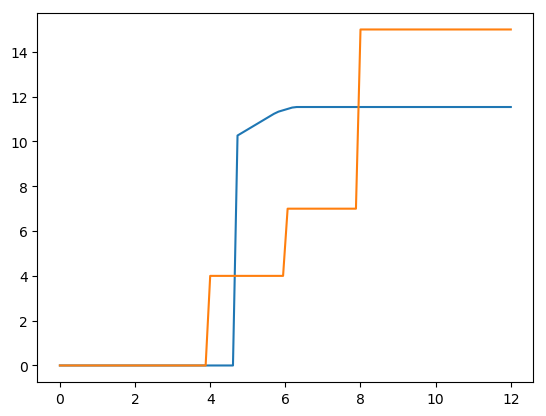

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000D37F28>

In [12]:
using PyPlot

function UIpolicy_quebec(jobspell) ## from Canadian Statistics in 1986, Lin (1998)
    ## caveat: we only account for continuous employment spell
    ## jobspell is in months
    if jobspell < 20 * 12/52 ## no eligible below 20 weeks
        UImax = 0.
    else ## eligible
        if jobspell < 25 *12/52
            UImax = jobspell
        else
            UImax = 25. *12/52 + min( (jobspell-25*12/52) /2, 13 * 12/52)
        end
        UImax += min(32, (10-4)/0.5 * 2) * 12/52 ## 24 is regional component with 10% unemployment rate
        UImax = min(50*12/52 , UImax)
    end
    return(UImax)
end

function UIpolicy_france(jobspell) ## from DARES in 1999, caveat: we only account for continuous employment spell
    if jobspell < 4 ## no eligible below 4 months
        UImax = 0.
    elseif jobspell < 6
        UImax = 4
    elseif jobspell < 8
        UImax = 7
    elseif jobspell < 14
        UImax = 15
    else
        UImax = 30
    end
    return(UImax)
end

js =  range(0, stop= 12, length=100)
plot(js, map( UIpolicy_quebec , js))   
plot(js, map( UIpolicy_france , js))  

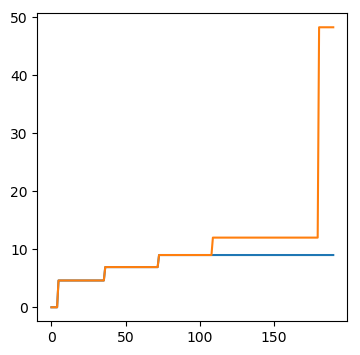

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001837BE0>

In [13]:
function UIpolicy_austria0(jobspell) ## source Lalive + http://www.oecd.org/els/soc/29725351.PDF
    ## caveat: we only account for continuous employment spell
    ## for workers 40-49
    ## jobspell is in month
    if jobspell < 20 * 12/52 ## no eligible below 20 weeks
        UImax = 0.
    elseif jobspell < 156 *12/52
        UImax = 20 * 12/52
    elseif jobspell < 312 *12/52
        UImax = 30 * 12/52
    else
        UImax = 39 * 12/52    
    end
    return(UImax)
end


function UIpolicy_austria1(jobspell) ## source Lalive + http://www.oecd.org/els/soc/29725351.PDF
    ## caveat: we only account for continuous employment spell
    if jobspell < 20 * 12/52 ## no eligible below 20 weeks
        UImax = 0.
    elseif jobspell < 156 *12/52
        UImax = 20 * 12/52
    elseif jobspell < 312 *12/52
        UImax = 30 * 12/52
    elseif jobspell < 468 *12/52
        UImax = 39 * 12/52
    elseif jobspell < 780 *12/52
        UImax = 52 * 12/52
    else
        UImax = 209 * 12/52    
    end
    return(UImax)
end

figure("",(4,4))
js =  range(0, stop= 190, length=200)
plot(js, map( UIpolicy_austria0 , js))  
figure("",(4,4))
plot(js, map( UIpolicy_austria1, js))   